# Step 3: Tomogram Refinement

In [1]:
from ddw import refine_tomogram
from ddw.utils.visualization import plot_tomo_slices
from ddw.utils.mrctools import load_mrc_data
from ddw.utils.print import print_help_for_function_arguments


## Refining the Tutorial Data

The `ddw refine-tomogram` produces the final denoised and missing-wedge-corrected tomogram(s) using the model we fitted in Step 2.

In [2]:
!conda run --no-capture-output -n ddw_env ddw refine-tomogram --config ./config.yaml

Lightning automatically upgraded your loaded checkpoint from v1.8.0.post1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file tutorial_project/logs/version_0/checkpoints/epoch/epoch=999.ckpt`
Computing model-input normalization statistics: 100%|█| 65/65 [01:33<00:00,  1.4
Refining tomo0:   0%|                                   | 0/114 [00:00<?, ?it/s]/opt/conda/envs/ddw_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(
Refining tomo1: 100%|█████████████████████████| 114/114 [01:23<00:00,  1.36it/s]
Saving refined tomogram to tutorial_project/refined_tomograms/tomo_even_frames+tomo_odd_frames_refined.rec


Let's have a look at the FBP reconstruction and the tomogram refined with DeepDeWedge:

In [5]:
tomo_ref.shape

torch.Size([209, 1280, 1238])

FileNotFoundError: [Errno 2] No such file or directory: './tutorial_data/tomo_full.mrc'

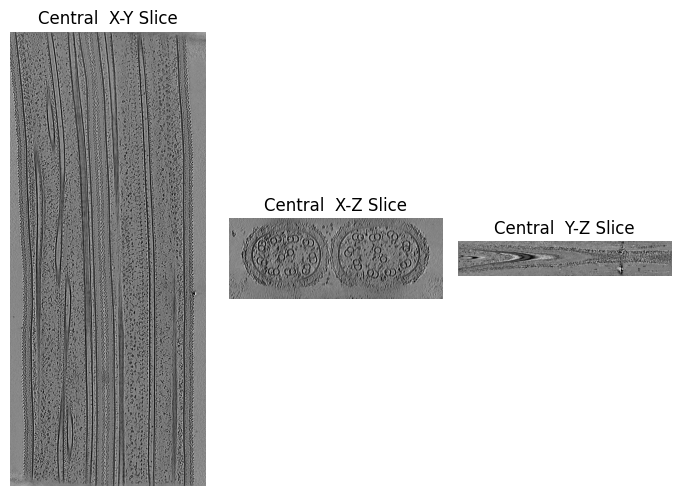

In [10]:
tomo_ddw = load_mrc_data("./tutorial_project/refined_tomograms/tomo_even_frames+tomo_odd_frames_refined.rec")
plot_tomo_slices(tomo_ddw[..., 350:900].clamp(-3*tomo_ddw.std(), 3*tomo_ddw.std())).show()

tomo_fbp = load_mrc_data("./tutorial_data/tomo_all_frames.rec")
plot_tomo_slices(tomo_fbp[..., 350:900].clamp(-3*tomo_fbp.std(), 3*tomo_fbp.std())).show()

## Most Important Parameters of `refine-tomogram` 

You can find a full list of parameters for `ddw refine-tomogram` by executing
```
conda run -n ddw_env ddw refine-tomogram --help
```
in the commandline. Here, we only discuss the most important parameters. The required parameters, which cover the most relevant functionality for most users, are:

In [11]:
print_help_for_function_arguments(refine_tomogram, print_only_required=True)

ARGUMENT 'tomo0_files'
	REQUIRED: True
	HELP: List of paths to tomograms (mrc files) reconstructed from one half of the tilt series or movie frames.
ARGUMENT 'tomo1_files'
	REQUIRED: True
	HELP: List of paths to tomograms (mrc files) reconstructed from the other half of the tilt series or movie frames.
ARGUMENT 'model_checkpoint_file'
	REQUIRED: True
	HELP: Path to a model checkpoint file (.ckpt extension). Checkpoints saved during model fitting can be found in the 'logdir' directory specifed for the 'fit-model' command.
ARGUMENT 'subtomo_size'
	REQUIRED: True
	HELP: Size of the cubic subtomograms to extract. This should be the same as the subtomo_size used during model fitting.


Model checkpoints can be found in the logging directory used during `ddw fit-model`, which is typically `{project_dir}/logs`. In this concrete case, the `tutorial_project/logs` directory contains model checkpoints for various epochs, as well as those achieving the lowest validation and fitting losses. The frequency and number of checkpoints created is controlled by arguments during model fitting, see `ddw fit-model --help` for more information. 

**Note:** In general, using the checkpoint at the latest epoch should be OK, but trying out the checkpoints with the lowest fitting and validation losses may lead to better results.